<a href="https://colab.research.google.com/github/joydeep03564/Machine_Learning-/blob/master/Multiclass_classification_PubMed_RCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Building an NLP model to make reading medical abstracts easier:**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this project,we address the problem of a researcher skiming through different research paper.Classifying each sentence of an abstruct will help the reseacher to read the abstruct efficiently. 
For this project, we will use the PubMed 20K RCT(randomised controlled trials). Every year over 1 million RCT have been published and that is what is the challenge of Medical professional to pin point a perticular abtract.
For dataset, the following paper is refered.
https://arxiv.org/abs/1710.06071

For implementation, we will be following the paper below:

https://arxiv.org/pdf/1612.05251.pdf



### Problem Statement: 
The problem can be posed as multiclass classification problem.We have classify each sentence as objctive, conclusion etc.

### Getting the Data:

The Authors of the papers makes the data available in github and its free. 
We will download the dataset from the authors git hub repo.


In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Checking the content of PubMed_20k_RCT_numbers_replaced_with_at_sign
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign


dev.txt  test.txt  train.txt


In [4]:
# We are going to start the project using Pubmed20K -RCT  

data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
import os

filenames =[data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data:

We have the text file and its time to preprocess them and convert it to tensorflow/dataframe so that we can apply our general process of tokenisation, embedding and finally feed to the machine learning models.



In [6]:
# We will read the files using python:

def get_lines(filename):

  """
  Reads filename(a text filename) and returns the lines of text as a list.
  Args:
  filename: a string contaning the target filepath
  return : 
  A list of strings with one string per line from the target filename.
  """
  with open(filename,"r") as f:
    return f.readlines()

In [7]:
# lets read in the training lines:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

### Preprocessing the text file:
For each of the text, we will create a list of dictionary like this
'''
[{'line_number': 0,
   'target':'BACKGROUND'
   'text':"Emotional eating is associated with overeating and the development of obesity"
   'total_lines':11]
'''

In [9]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [10]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))


180040 30212 30135
CPU times: user 522 ms, sys: 93.7 ms, total: 615 ms
Wall time: 616 ms


In [11]:
train_samples[:20]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [12]:
 import pandas as pd

 train_df=pd.DataFrame(train_samples)
 val_df = pd.DataFrame(val_samples)
 test_df = pd.DataFrame(test_samples)

In [13]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


Now we have the dataframe for the 3. Train,Test and  validation.
We will check the labels and its distibution 

In [14]:
train_df['target'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

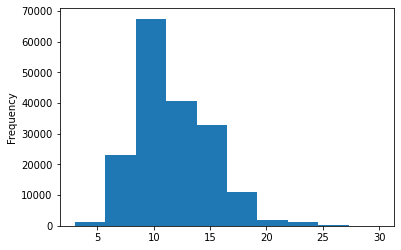

In [15]:
# Lets check the length of different lines
train_df['total_lines'].plot.hist()

### Get lists of sentences:
This will our feature 

In [16]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
print(len(train_sentences),len(val_sentences),len(test_sentences))

180040 30212 30135


### Numerical Encoding of Labels:

While encoding the labels into one hot encoding, we have to use sparse = false as tensor flow can't work with sparse representatio.
Hence in this case, we will use sparse = false.

When we run onehot encoding with one dimentional data, we get this error msg. We have to reshape the data into(-1,1)

```
# ValueError: Expected 2D array, got 1D array instead:
array=['OBJECTIVE' 'METHODS' 'METHODS' ... 'RESULTS' 'CONCLUSIONS' 'CONCLUSIONS'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
```





In [17]:
# One hot encoding labels

from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))

val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))
print(train_labels_one_hot[0])
print(val_labels_one_hot[0])
print(test_labels_one_hot[0])


[0. 0. 0. 1. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]


In [18]:
import tensorflow as tf

tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### Label ecoding using labels

In [19]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

print(train_labels_encoded)


[3 2 2 ... 4 1 1]


# Base line model with Naive Bayes and TFIDF:

Here in this case, we will be using multinomial Naive Bayes and TFIDF.


In [20]:
# Creating the base line model with Naive Bayes.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline 

model_0 = Pipeline([
                    ("tf-idf",TfidfVectorizer()),
                    ("Clf",MultinomialNB())
])

model_0.fit(X= train_sentences,
            y = train_labels_encoded)

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('Clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [21]:
# Evaluate the dataset on validation dataset

model_0.score(X=val_sentences,y=val_labels_encoded)

0.7218323844829869

In [22]:
# Make prediction

baseline_preds = model_0.predict(val_sentences)

baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Base line model evaluation  :

For model evaluation, we are going to use the helper function that is created in an earlier project. we arte going to download that from the directory.
https://raw.githubusercontent.com/joydeep03564/Machine_Learning-/master/helper_functions.py



In [23]:
!wget https://raw.githubusercontent.com/joydeep03564/Machine_Learning-/master/helper_functions.py


--2021-07-21 09:50:40--  https://raw.githubusercontent.com/joydeep03564/Machine_Learning-/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4021 (3.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   3.93K  --.-KB/s    in 0s      

2021-07-21 09:50:40 (50.1 MB/s) - ‘helper_functions.py’ saved [4021/4021]



In [24]:
from helper_functions import model_evaluation_matrix

In [25]:
baseline_results = model_evaluation_matrix(y_true= val_labels_encoded,y_pred=baseline_preds)

print(baseline_results)

{'accuracy': 0.7218323844829869, 'precision': 0.7186466952323352, 'recall': 0.7218323844829869, 'f1 score': 0.6989250353450294}


# Building the deep sequence neural network:

## Preparing the data for deep neural models:

In [26]:
# Preparing the data for deep sequence models:

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers 
import matplotlib.pyplot as plt



In [27]:
# Before we build tokensization layer, it is important to know how long is each sentence is/or 90 percentile of the sentences 
# How long is each sentence length on an average
average_train_sentences_length = np.mean([len(each_sentence.split()) for each_sentence in train_sentences ])


In [28]:
average_train_sentences_length

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

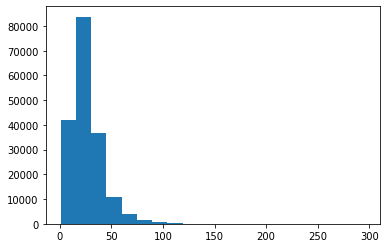

In [29]:
# what's the distribution look like?

sentence_length= [len(each_sentence.split()) for each_sentence in train_sentences]
plt.hist(sentence_length,bins=20)

In [30]:
np.percentile(sentence_length,95 )

55.0

In [31]:
output_seq = int(np.percentile(sentence_length,95))

In [32]:
MAX_tokens = 68000

In [33]:
# Create Text Vectorizer 
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens= 68000,output_sequence_length = output_seq)


In [34]:
# Adapt text Vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [35]:
import random 

target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of the text is {len(target_sentence.split())}")
print(f"\n Vectorized text: {text_vectorizer([target_sentence])}")

Text:
we compared hemodynamic variables , fluid intake , renal function and urine output between groups .

Length of the text is 16

 Vectorized text: [[  43   34 1273  498  796  399  474  149    3  943 1894   30   24    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [36]:
# How many words in our vocabulary 

rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of total words in the vocab is {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Most least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of total words in the vocab is 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Most least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [37]:
text_vectorizer.get_config()

{'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary_size': 64841}

### Creating custom text embedding layer:


In [38]:
# Create token embedding layer

token_embedding = layers.Embedding(input_dim=len(rct_20k_text_vocab ),output_dim=128,mask_zero= True,name="Token_embedding")

In [39]:
print(f"Sentence before Vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after Vectotization:\n{vectorized_sentence}")  
embedded_sentence = token_embedding(vectorized_sentence)
print("\n")
print(f"Sentence after embedding is:\n {embedded_sentence}")
print(embedded_sentence.shape)

Sentence before Vectorization:
 we compared hemodynamic variables , fluid intake , renal function and urine output between groups .

Sentence after Vectotization:
[[  43   34 1273  498  796  399  474  149    3  943 1894   30   24    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


Sentence after embedding is:
 [[[ 0.02860843  0.00633755 -0.00562488 ... -0.0424036   0.00535566
   -0.03310673]
  [-0.01516481 -0.00028448  0.02665691 ... -0.04309812 -0.02167821
   -0.04406685]
  [ 0.02236886  0.04192123  0.04794208 ... -0.01087022  0.03781832
    0.02486611]
  ...
  [ 0.040606    0.00566681 -0.03065532 ...  0.03641062  0.03868293
   -0.02202722]
  [ 0.040606    0.00566681 -0.03065532 ...  0.03641062  0.03868293
   -0.02202722]
  [ 0.040606    0.00566681 -0.03065532 ...  0.03641062  0.03868293
   -0.02202722]]]
(1, 55, 128)


### Creating the tensorflow dataset:
We'r going to create our dataset so that it runs faster. We are going to use tf.data.Dataset API


In [40]:
# Turn our data into tensorflow datatset

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_datatset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

In [41]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_datatset = valid_datatset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [42]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [43]:
len(train_dataset)

5627

### Building the Cov1D with token embedding 
We will create the model for Cov1D

In [44]:
inputs = layers.Input(shape=(1,),dtype=tf.string) # inputs layer taken in each sentences 
text_vectors = text_vectorizer(inputs)           # vectorise text inputs 
token_embedding = token_embedding(text_vectors)  # create embedding
x = layers.Conv1D(64,kernel_size=5,padding='same',activation="relu")(token_embedding)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5,activation="softmax")(x)

model_1 = tf.keras.Model(inputs,outputs)

# Compile the model:

model_1.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])



In [45]:
model_1.summary

<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x7fc518b84e90>>

In [46]:
# We are using only 10% of the dataset for the training here as we want to reduce the time to train
# We are using the atribute steps_per_epochs attribute to perform that
history_model_1 = model_1.fit(train_dataset,steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs = 3,
                              validation_data = valid_datatset,
                              validation_steps =int(0.1*len(valid_datatset)))

Epoch 1/3
562/562 [==============================] - 78s 83ms/step - loss: 0.9210 - accuracy: 0.6376 - val_loss: 0.6828 - val_accuracy: 0.7394
Epoch 2/3
562/562 [==============================] - 46s 83ms/step - loss: 0.6595 - accuracy: 0.7552 - val_loss: 0.6328 - val_accuracy: 0.7693
Epoch 3/3
562/562 [==============================] - 47s 83ms/step - loss: 0.6205 - accuracy: 0.7725 - val_loss: 0.6011 - val_accuracy: 0.7846


In [47]:
# Evaluate on whole validation dataset:
model_1.evaluate(valid_datatset)

945/945 [==============================] - 3s 4ms/step - loss: 0.6032 - accuracy: 0.7851


[0.6032207012176514, 0.7850522994995117]

In [48]:
model_1_pred_probs = model_1.predict(valid_datatset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.5913106e-01, 1.7035693e-01, 8.2321063e-02, 2.4883573e-01,
         3.9355315e-02],
        [4.1808209e-01, 2.9792503e-01, 1.2260695e-02, 2.6446524e-01,
         7.2669960e-03],
        [1.5321139e-01, 1.0083755e-02, 2.1197298e-03, 8.3454919e-01,
         3.5880370e-05],
        ...,
        [5.5381593e-06, 5.4390187e-04, 6.7984231e-04, 2.0305140e-06,
         9.9876863e-01],
        [5.4464102e-02, 4.8809972e-01, 8.7458439e-02, 6.7931049e-02,
         3.0204663e-01],
        [1.4376839e-01, 6.6592252e-01, 3.1343911e-02, 5.7390578e-02,
         1.0157464e-01]], dtype=float32), (30212, 5))

In [49]:
model_1_preds = tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [50]:
model_1_results = model_evaluation_matrix(y_true=val_labels_encoded,y_pred=model_1_preds)

model_1_results 

{'accuracy': 0.7850522971004898,
 'f1 score': 0.7824232993915439,
 'precision': 0.7818070190354568,
 'recall': 0.7850522971004898}

### Model 2: Feature extraction using preptrained token embeddings

Now lets use the pretrained sentence encoders from Tensorflow Hub, more specifically the universal sentence encoder:
https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used Glove emdedding, however,we're going to stick with the later created USE pretrained embedding 


In [51]:
# Download pretrained Tensorflow Hub USE

import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",trainable = False,name="universal_sentence_encoder")

In [52]:
random_train_sentence = random.choice(train_sentences)
print(f"Random Sentence\n:{random_train_sentence}")
print(f" The embedding sentence:\n is {tf_hub_embedding_layer([random_train_sentence])}")

Random Sentence
:dual-energy x-ray absorptiometry ( dxa ) scans from @ hiv-infected adults randomised to simplify their existing dual nucleoside analogue reverse transcriptase inhibitor therapy to coformulated tenofovir-emtricitabine or abacavir-lamivudine were analysed using dxa-derived hip structural analysis software .
 The embedding sentence:
 is [[-0.05756668  0.00755258 -0.06062604 -0.02932074 -0.05935215 -0.02773248
  -0.05571362  0.01653929 -0.02626612  0.05227515  0.07792827 -0.07786644
   0.04308835  0.00981571  0.00040137 -0.03270322 -0.07352748  0.00910835
   0.06438576  0.02859113  0.03346201  0.07322077 -0.05843283  0.02465279
   0.02986895  0.05524403  0.0227467   0.05810003 -0.05473039 -0.02674458
   0.00232994  0.07972623  0.05612796  0.03403882 -0.06738184 -0.02309451
   0.00441838  0.03371576 -0.07734049 -0.04684371  0.00855837 -0.03289664
   0.00388593 -0.04668445  0.03236615 -0.0169002   0.01003844 -0.03303254
   0.01955307  0.04847974 -0.05036137  0.00084392 -0.03

In [53]:
# Creating a small nueral network 

inputs = layers.Input(shape=[],dtype=tf.string)
embedding_layer = tf_hub_embedding_layer(inputs)
#x = layers.GlobalAveragePooling1D()(embedding_layer)
x = layers.Dense(128,activation='relu')(embedding_layer)
output = layers.Dense(5,activation='softmax')(x)

model_2 = tf.keras.Model(inputs,output,name="model_2_USE_feature_extractor")

model_2.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

model_2.fit(train_dataset,
            epochs=3,
            steps_per_epoch=int(0.1*len(train_dataset)),
            validation_data= valid_datatset,
            validation_steps = int(0.1* len(valid_datatset))
)


Epoch 1/3
562/562 [==============================] - 9s 13ms/step - loss: 0.9217 - accuracy: 0.6436 - val_loss: 0.7952 - val_accuracy: 0.6895
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7676 - accuracy: 0.7037 - val_loss: 0.7508 - val_accuracy: 0.7084
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7502 - accuracy: 0.7129 - val_loss: 0.7354 - val_accuracy: 0.7174


In [54]:
model_2.evaluate(valid_datatset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7385 - accuracy: 0.7148


[0.7384938597679138, 0.7148153185844421]

In [55]:
model_2_predict_probs = model_2.predict(valid_datatset)
model_2_predict_probs

array([[4.3132031e-01, 3.5181099e-01, 1.9645323e-03, 2.0798638e-01,
        6.9177789e-03],
       [3.2552809e-01, 5.0788778e-01, 4.1561881e-03, 1.5932713e-01,
        3.1008292e-03],
       [2.1007317e-01, 1.4593689e-01, 1.6475428e-02, 5.8690417e-01,
        4.0610358e-02],
       ...,
       [1.8716265e-03, 4.7358200e-03, 5.7620008e-02, 9.2702825e-04,
        9.3484551e-01],
       [4.2168838e-03, 4.6281569e-02, 2.3494938e-01, 1.6870907e-03,
        7.1286505e-01],
       [1.6736576e-01, 2.6382831e-01, 5.0646055e-01, 6.3283541e-03,
        5.6017037e-02]], dtype=float32)

In [56]:
model_2_preds = tf.argmax(model_2_predict_probs,axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [57]:
# Calculate results from TFhub pretrained embedding results 
model_2_results= model_evaluation_matrix(y_true=val_labels_encoded,y_pred=model_2_preds)
model_2_results

{'accuracy': 0.714815305176751,
 'f1 score': 0.7116229110752667,
 'precision': 0.71470254257392,
 'recall': 0.714815305176751}

# Model_3 : Conv1D with Chatacter embeddings 

The paper we are replicating states that they are using combnation of chatecter-lavel embedding along with token level embedding.
In this section, we will try to  build similar steps of charecter embeddings

### Character label tokenizer

In [58]:
def split_chars(text):
  return " ".join(list(text))

split_chars(random_train_sentence)

'd u a l - e n e r g y   x - r a y   a b s o r p t i o m e t r y   (   d x a   )   s c a n s   f r o m   @   h i v - i n f e c t e d   a d u l t s   r a n d o m i s e d   t o   s i m p l i f y   t h e i r   e x i s t i n g   d u a l   n u c l e o s i d e   a n a l o g u e   r e v e r s e   t r a n s c r i p t a s e   i n h i b i t o r   t h e r a p y   t o   c o f o r m u l a t e d   t e n o f o v i r - e m t r i c i t a b i n e   o r   a b a c a v i r - l a m i v u d i n e   w e r e   a n a l y s e d   u s i n g   d x a - d e r i v e d   h i p   s t r u c t u r a l   a n a l y s i s   s o f t w a r e   .'

In [59]:
train_chars = [split_chars(sentence) for sentence in train_sentences ]
val_chars = [split_chars(sentences) for sentences in val_sentences]
test_chars = [split_chars(sentences) for sentences in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [60]:
# what is the average length of characters in the train sentence

char_length = [len(sentence)for sentence in train_sentences]
mean_char_length = np.mean(char_length)
print(mean_char_length)

149.3662574983337


In [61]:
output_char_length = int(np.percentile(char_length,95))
print(output_char_length)

290


(array([9.2691e+04, 7.6343e+04, 9.6890e+03, 1.0890e+03, 1.6700e+02,
        4.2000e+01, 1.3000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 1.3950e+02, 2.7800e+02, 4.1650e+02, 5.5500e+02,
        6.9350e+02, 8.3200e+02, 9.7050e+02, 1.1090e+03, 1.2475e+03,
        1.3860e+03]),
 <a list of 10 Patch objects>)

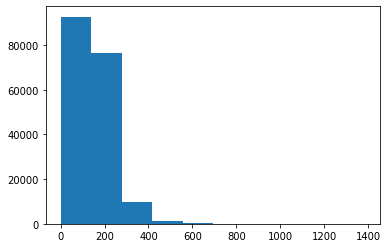

In [62]:
import matplotlib.pyplot as plt
plt.hist(char_length,bins=10)

In [63]:
# In Python we can use to find all the keyboard keys 

import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation
print(alphabet)

abcdefghijklmnopqrstuvwxyz0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [64]:
NUM_CHAR_TOKENS = len(alphabet)+2 # add 2 for space and OOV tokens 

char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,output_sequence_length=output_char_length) # Created the char label Vectoriser 

In [65]:
# Adapt character vectorizer 

char_vectorizer.adapt(train_chars)

In [66]:
# Checking charecter vocab stats 

char_vocab = char_vectorizer.get_vocabulary()
print(f"The size of the vocab: {len(char_vocab)}")
print(f"The most common vocab:\n {char_vocab[:5]}")
print(f"The least common vocab:\ {char_vocab[-5:]}")

The size of the vocab: 28
The most common vocab:
 ['', '[UNK]', 'e', 't', 'i']
The least common vocab:\ ['k', 'x', 'z', 'q', 'j']


In [67]:
#Test our char vectorizer 

random_char = random.choice(train_chars)

print(f"The random char sentence is :\n {random_char}")
char_vector_rep = char_vectorizer([random_char])
print('\n')
print('\n')
print(f"The vectorized representation is :\n {char_vector_rep}")

The random char sentence is :
 r i s k   f a c t o r s   h a v e   b e e n   p r o p o s e d   f o r   r u n n i n g   i n j u r i e s   i n c l u d i n g   (   a   )   r e d u c e d   m u s c u l a r   s t r e n g t h   ,   (   b   )   e x c e s s i v e   j o i n t   m o v e m e n t s   a n d   (   c   )   e x c e s s i v e   j o i n t   m o m e n t s   i n   t h e   f r o n t a l   a n d   t r a n s v e r s e   p l a n e s   .




The vectorized representation is :
 [[ 8  4  9 23 17  5 11  3  7  8  9 13  5 21  2 22  2  2  6 14  8  7 14  7
   9  2 10 17  7  8  8 16  6  6  4  6 18  4  6 27 16  8  4  2  9  4  6 11
  12 16 10  4  6 18  5  8  2 10 16 11  2 10 15 16  9 11 16 12  5  8  9  3
   8  2  6 18  3 13 22  2 24 11  2  9  9  4 21  2 27  7  4  6  3 15  7 21
   2 15  2  6  3  9  5  6 10 11  2 24 11  2  9  9  4 21  2 27  7  4  6  3
  15  7 15  2  6  3  9  4  6  3 13  2 17  8  7  6  3  5 12  5  6 10  3  8
   5  6  9 21  2  8  9  2 14 12  5  6  2  9  0  0  0  0  0  0  0  0  0  0
   0  0  

##Creating a character level embedding:


In [68]:
char_embed = layers.Embedding(input_dim=len(char_vocab),output_dim=25,mask_zero=True,name="char_embed")

In [69]:
# Testing our Char embed
print(f"Charified text:\n {random_char}")

char_embed_example = char_embed(char_vectorizer([random_char]))

print(f"Embedded chars(after vectorization and embedding):\n{char_embed_example}\n")
print(f"character embedding shape: {char_embed_example.shape}")


Charified text:
 r i s k   f a c t o r s   h a v e   b e e n   p r o p o s e d   f o r   r u n n i n g   i n j u r i e s   i n c l u d i n g   (   a   )   r e d u c e d   m u s c u l a r   s t r e n g t h   ,   (   b   )   e x c e s s i v e   j o i n t   m o v e m e n t s   a n d   (   c   )   e x c e s s i v e   j o i n t   m o m e n t s   i n   t h e   f r o n t a l   a n d   t r a n s v e r s e   p l a n e s   .
Embedded chars(after vectorization and embedding):
[[[-0.02426467  0.03114216 -0.00811598 ... -0.01009147 -0.00685481
    0.00539137]
  [-0.03793272 -0.03290246  0.04205677 ... -0.01000331  0.01485548
   -0.01126777]
  [-0.044119   -0.04791803  0.00909337 ...  0.04112614  0.02754866
    0.01756364]
  ...
  [-0.04037607  0.02668308  0.03356692 ...  0.01165037  0.00475389
   -0.01186927]
  [-0.04037607  0.02668308  0.03356692 ...  0.01165037  0.00475389
   -0.01186927]
  [-0.04037607  0.02668308  0.03356692 ...  0.01165037  0.00475389
   -0.01186927]]]

character embedding sha

### Building the Cov1D model_3 with char lavel embedding:



In [70]:
inputs = layers.Input(shape=(1,),dtype=tf.string)

char_vectorization  = char_vectorizer(inputs)

char_embedding = char_embed(char_vectorization)
#x = layers.AveragePooling1D(char_embedding)
x = layers.Conv1D(64,5,padding='same',activation='relu')(char_embedding)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(5,activation='softmax')(x)

model_3 = tf.keras.Model(inputs=inputs,outputs=outputs,name="model_3_char_embeddings")

# compile

model_3.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])



In [71]:
model_3.summary()

Model: "model_3_char_embeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           700       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________

### Create char lavel dataset

In [72]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [73]:
model_3_history = model_3.fit(train_char_dataset,epochs=3,steps_per_epoch= int(0.1*len(train_char_dataset)),validation_data=val_char_dataset,validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 1.2533 - accuracy: 0.4904 - val_loss: 1.0429 - val_accuracy: 0.5938
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 0.9847 - accuracy: 0.6046 - val_loss: 0.9182 - val_accuracy: 0.6446
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.9018 - accuracy: 0.6491 - val_loss: 0.8448 - val_accuracy: 0.6762


In [74]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.8624 - accuracy: 0.6674


[0.8624127507209778, 0.6674169301986694]

In [75]:
model_3_pred_proba = model_3.predict(val_char_dataset)

model_3_pred_proba

array([[0.18526931, 0.33287114, 0.11367016, 0.3067824 , 0.06140699],
       [0.24642037, 0.46131033, 0.0014751 , 0.2717668 , 0.01902737],
       [0.13484375, 0.10884093, 0.1147321 , 0.5520091 , 0.08957412],
       ...,
       [0.02132639, 0.04711298, 0.1344781 , 0.01916509, 0.77791744],
       [0.0656733 , 0.2335598 , 0.34097242, 0.06712124, 0.29267323],
       [0.53010964, 0.3387985 , 0.06257736, 0.05935087, 0.0091636 ]],
      dtype=float32)

In [76]:
# convert prediction probabilities to class labels

model_3_preds = tf.argmax(model_3_pred_proba,axis=1)

In [77]:
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 2, 0])>

In [78]:
# Calculate the results of the model_3
model_3_results = model_evaluation_matrix(y_true= val_labels_encoded,y_pred=model_3_preds)

model_3_results

{'accuracy': 0.6674169204289686,
 'f1 score': 0.658222454404624,
 'precision': 0.6623667064239384,
 'recall': 0.6674169204289686}

# Building Model 4 using  mutiple inputs:

We will use pretrained token embeddings and charecters embeddings(hybrid embedding)

1. Create a token-lavel embedding model(similar 'Model_1'
2. Create a character lavel embedding(similar to Model 3 with slight modification)
3. Combine 1& 2 with a concatenate(layers.Concatenate)
4. BUild a series of output layers on top of 3 as in the paper fig1
5. Construct a model which takes tokens and charecter-lavels sequence as input and produces an ouput.

In [138]:
# setup the token inputs/model and going to use functonal api

# 1. Set up the token input/output model
token_inputs = layers.Input(shape=[],dtype= tf.string)
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128,activation='relu')(token_embeddings)

token_model = tf.keras.Model(inputs = token_inputs,outputs = token_outputs)

# 2. Set up char inputs/model

char_inputs = layers.Input(shape=(1,),dtype=tf.string)
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_directional_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)

char_model = tf.keras.Model(inputs=char_inputs,outputs=char_bi_directional_lstm)

# 3. Set up char tokens and char inputs (create hybrid token embedding)

token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output,char_model.output])


# 4. Creating output layers-adding in dropout 

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128,activation='relu')(combined_dropout)
final_dropout =  layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5,activation ='softmax')(final_dropout)

# 5. Construct model with char and tokens inputs 

model_4 = tf.keras.Model(inputs=[token_model.input,char_model.input],outputs= output_layer,name='model_4')


In [139]:
model_4.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
text_vectorization_1 (TextVecto (None, 290)          0           input_7[0][0]                    
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   input_6[0][0]                    
____________________________________________________________________________________________

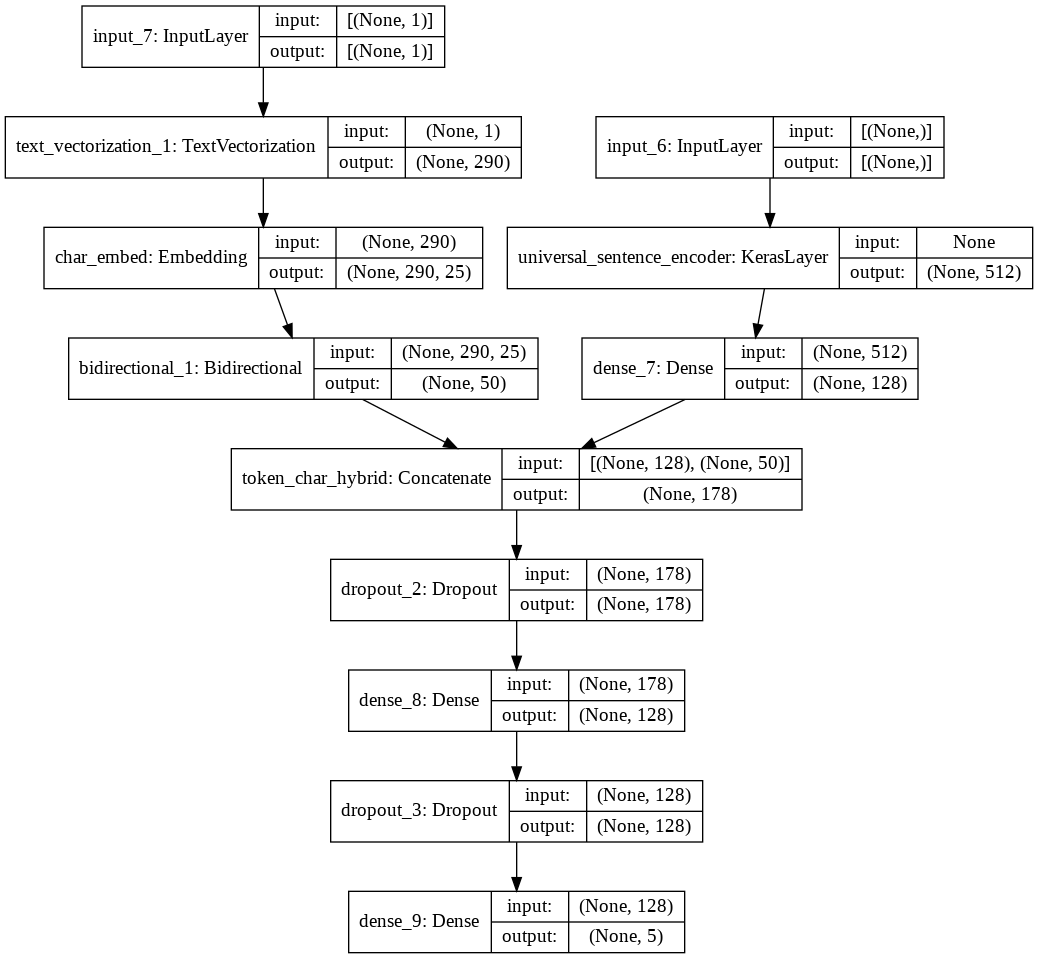

In [140]:
#from keras.utils import plot_model
#plot_model(model_4)
from keras.utils.vis_utils import plot_model

plot_model(model_4,show_shapes=True)

### Creating tensorflow datatset:


In [141]:
#compile token char model

model_4.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combinnng token and characters :


In [142]:
# combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [143]:

# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

Fitting the model on tokens and charecters-level senquence

In [144]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 41s 59ms/step - loss: 0.9873 - accuracy: 0.6074 - val_loss: 0.7825 - val_accuracy: 0.7068
Epoch 2/3
562/562 [==============================] - 30s 53ms/step - loss: 0.8044 - accuracy: 0.6886 - val_loss: 0.7205 - val_accuracy: 0.7261
Epoch 3/3
562/562 [==============================] - 28s 50ms/step - loss: 0.7745 - accuracy: 0.7031 - val_loss: 0.6892 - val_accuracy: 0.7434
